In [1]:
%pylab inline

from __future__ import print_function
import numpy as np
import theano
import theano.tensor as T
import time
import datetime
import os

import lasagne
from copy import deepcopy

import SimpleITK as sitk
import random
from skimage import exposure
from skimage.morphology import binary_closing

import sklearn.cross_validation

Populating the interactive namespace from numpy and matplotlib
Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K40c (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5004)
/usr/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def extract_patches(mri, label, half_patch_size=5, negative_subsample_ratio=200):
    
    assert mri.shape == label.shape
    
    z_size, x_size, y_size = mri.shape
    positive_patches = []
    negative_patches = []
    
    if np.sum(label) <= 0.5:
        return ([], [])

    for z in xrange(half_patch_size, z_size-half_patch_size):
        if label[z,:,:].sum() > 1000: continue # workaround to remove white slices into the label dataset
        for x in xrange(half_patch_size, x_size-half_patch_size):
            for y in xrange(half_patch_size, y_size-half_patch_size):
                if label[z,x,y] == 1:
                    positive_patches.append(mri[z-half_patch_size:z+half_patch_size+1,x-half_patch_size:x+half_patch_size+1,y-half_patch_size:y+half_patch_size+1])
                elif label[z,x,y] == 0:
                    negative_patches.append(mri[z-half_patch_size:z+half_patch_size+1,x-half_patch_size:x+half_patch_size+1,y-half_patch_size:y+half_patch_size+1])
    
    random.shuffle(negative_patches)
    number_of_negative_cases = int(len(negative_patches) / float(negative_subsample_ratio))
    selected_negative_patches = deepcopy(negative_patches[:number_of_negative_cases])
    del(negative_patches)
    
    return (positive_patches, selected_negative_patches)

In [3]:
def patchimg2differentview(patch):
    
    z_size, x_size, y_size = patch.shape
    
    X = np.zeros((z_size * 3, x_size, y_size), dtype=np.float32)
    
    counter = 0
    for z in xrange(z_size):
        X[counter,:,:] = patch[z,:,:]
        counter += 1
    for x in xrange(x_size):
        X[counter,:,:] = patch[:,x,:]
        counter += 1
    for y in xrange(y_size):
        X[counter,:,:] = patch[:,:,y]
        counter += 1
    
    return X.astype(np.float32)

In [4]:
def patches2CNNformat(patches, label, half_patch_size=5):
    
    X = np.zeros((len(patches), (2 * half_patch_size)+1, (half_patch_size*2)+1, (half_patch_size*2)+1), dtype=np.float32)
    y = np.zeros((len(patches)), dtype=np.int32) * -1
    
    for i, patch in enumerate(patches):
        #X[i,:,:,:] = patchimg2differentview(patch)
        X[i,:,:,:] = patch
        y[i] = label
    
    assert -1 not in y
    
    return X.astype(np.float32), y.astype(np.int32)

In [5]:
def get_resized_img(img, data_type = sitk.sitkFloat32):
    
    size = img.GetSize()
    ratio = [1.0/i for i in img.GetSpacing()]
    new_size = [int(size[i]/ratio[i]) for i in range(3)]
    
    rimage = sitk.Image(new_size, data_type)
    rimage.SetSpacing((1,1,1))
    rimage.SetOrigin(img.GetOrigin())
    tx = sitk.Transform()
    
    interp = sitk.sitkLinear
    if data_type == sitk.sitkInt16:
        interp = sitk.sitkNearestNeighbor
    
    new_image = sitk.Resample(img, rimage, tx, interp, data_type)
    
    return sitk.GetArrayFromImage(new_image)

In [6]:
def needles2tips(only_needles, image_array, number_of_slices=3):
    needles_masks_array = np.zeros_like(image_array).astype(float)  
    for file_item in only_needles:
        this_mask = file_item.astype(np.float)
        if np.sum(this_mask) < (np.shape(this_mask)[0] * np.shape(this_mask)[1] * np.shape(this_mask)[2]):
            this_mask = binary_closing(this_mask,selem=np.ones((3,3,3)))
            found=False
            row = np.shape(this_mask)[0]-1
            while found==False and row > 0: #< np.shape(this_mask)[0]-1 :
                #print(row)
                this_row = this_mask[row,:,:]
                if np.sum(this_row) > 0:
                    #print(row)
                    found = True
                    temp = np.add(needles_masks_array[row:row+1+number_of_slices,:,:],this_mask[row:row+1+number_of_slices,:,:])
                    temp[temp!=0] = 1
                    needles_masks_array[row:row+1+number_of_slices,:,:] = temp 
                row -= 1
    return needles_masks_array.astype(np.int32)

In [7]:
def needles2tips_PAOLO(needles, mri, number_of_slices=3):
    tips = np.zeros_like(mri).astype(np.int32)
    #print(tips.shape)
    for needle in needles:
        needle = needle.astype(np.int32)
        #print("MIN %f, MAX %f" % (needle.min(), needle.max()))
        if np.sum(needle) < (np.shape(needle)[0] * np.shape(needle)[1] * np.shape(needle)[2]):
            #print("Valid needle")
            needle = binary_closing(needle, selem=np.ones((3,3,3)))
            needle[needle!=0]=1
            #print(" after closing: MIN %f, MAX %f " % (needle.min(), needle.max()))
            for z in range(np.shape(mri)[0]-1, 0, -1):
                if 200 > np.sum(needle[z,:,:]) > 0.5 and z-number_of_slices-1 >= 0:
                    #print(" valid slice %d" % z)
                    tmp = deepcopy(needle)
                    tmp[:z-number_of_slices-1,:,:] = 0
                    tips[tmp!=0] = 1
                    del(tmp)
                    break
    
    tips[tips!=0]=1
        
    return tips.astype(np.int32)

In [8]:
def merge_needles(needles, mri):
    all_needles = np.zeros_like(mri).astype(np.int32)
    
    for needle in needles:
        needle = needle.astype(np.int32)
        needle[needle!=0]=1
        
        if np.sum(needle) < (needle.shape[0] * needle.shape[1] * needle.shape[2])/3.0:
            all_needles[needle!=0] = 1
    
    all_needles[all_needles!=0]=1
        
    return all_needles.astype(np.int32)

In [9]:
def pad_volume(img, half_patch_size=5):
    npad = ((half_patch_size,half_patch_size),(half_patch_size,half_patch_size),(half_patch_size,half_patch_size))
    return np.lib.pad(img, npad, "constant", constant_values=0)

In [10]:
def data_for_CNN(general_folder, half_patch_size=5):
    folders_cases = os.listdir(general_folder)
    
    X_pos = np.ones((1, (2 * half_patch_size)+1, (half_patch_size*2)+1, (half_patch_size*2)+1), dtype=np.float32) * -1.0
    y_pos = np.ones((1), dtype=np.int32) * -1.0
    
    X_neg = np.ones((1, (2 * half_patch_size)+1, (half_patch_size*2)+1, (half_patch_size*2)+1), dtype=np.float32) * -1.0
    y_neg = np.ones((1), dtype=np.int32) * -1.0
    
    for folder_case in folders_cases:
        print("Patient #%s" % (folder_case))
        full_case_path = general_folder + os.sep + folder_case
        
        volumetric_files = os.listdir(full_case_path)
        
        assert "case.nrrd" in volumetric_files
        del(volumetric_files[volumetric_files.index("case.nrrd")])
        print(" %d needles file" %  (len(volumetric_files)))

        
        mri_sitk = sitk.ReadImage(full_case_path + os.sep + "case.nrrd")
        
        needles = []
        valid_needles = 0
        for volumetric_file in volumetric_files:
            if volumetric_file == "labelmap.nrrd":
                pass
            label_sitk = sitk.ReadImage(full_case_path + os.sep + volumetric_file)
            label = sitk.GetArrayFromImage(label_sitk)
            background = int(np.around(np.percentile(label, 75), decimals=0))
            #print('Background %d' % background)
            filtered_label = np.zeros_like(label, dtype=np.int32)
            filtered_label[label!=background] = 1
            #print(np.sum(filtered_label))
            
            #label[label!=0]=1
            if np.sum(filtered_label)>0:
                needles.append(filtered_label)
                valid_needles += 1
                
        print(" %d valid needles" %  (valid_needles))
        
        tips = merge_needles(needles, sitk.GetArrayFromImage(mri_sitk))
        #tips_sitk = sitk.GetImageFromArray(tips)
        #tips_sitk.CopyInformation(mri_sitk)
        #tips = get_resized_img(tips_sitk, sitk.sitkInt16)
        tips = pad_volume(tips, half_patch_size=half_patch_size)
        tips[tips!=0]=1
        
        for z in range(tips.shape[0]):
            if np.sum(tips[z,:,:]) > 500:
                tips[z,:,:] = np.zeros_like(tips[z,:,:], dtype=np.int32)
        
        tips[tips!=0]=1
        tips = tips.astype(np.int32)
        #assert np.sum(tips) > 0.5
        
        mri = sitk.GetArrayFromImage(mri_sitk).astype(np.float32)
        mri = pad_volume(mri, half_patch_size=half_patch_size)
        
        # DEBUG
        #data_tag = str(datetime.datetime.now()).replace(" ", "_")
        #mri_sitk_DEBUG = sitk.GetImageFromArray(mri)
        #tips_sitk_DEBUG = sitk.GetImageFromArray(tips)
        #tips_sitk_DEBUG.CopyInformation(mri_sitk_DEBUG)
        #sitk.WriteImage(mri_sitk_DEBUG, "../DEBUG/mri_%s.nrrd" % data_tag)
        #sitk.WriteImage(tips_sitk_DEBUG, "../DEBUG/tips_%s.nrrd" % data_tag)
        
        positive_patches, negative_patches = extract_patches(mri, tips, half_patch_size=half_patch_size)
        if len(positive_patches) > 0:
            print(" %d positive patches and %d negative patches" % (len(positive_patches), len(negative_patches)))
            X_temp_pos, y_temp_pos = patches2CNNformat(positive_patches, 1, half_patch_size=half_patch_size)
            X_temp_neg, y_temp_neg = patches2CNNformat(negative_patches, 0, half_patch_size=half_patch_size)
            
            X_pos = np.concatenate((X_pos, X_temp_pos), axis=0)
            y_pos = np.concatenate((y_pos, y_temp_pos), axis=0)
            X_neg = np.concatenate((X_neg, X_temp_neg), axis=0)
            y_neg = np.concatenate((y_neg, y_temp_neg), axis=0)
    
    assert -1 in X_pos[0,:,:,:] and y_pos[0] == -1
    X_pos = X_pos[1:,:,:,:].astype(np.float32)
    y_pos = y_pos[1:].astype(np.int32)
    
    assert -1 in X_neg[0,:,:,:] and y_neg[0] == -1
    X_neg = X_neg[1:,:,:,:].astype(np.float32)
    y_neg = y_neg[1:].astype(np.int32)
    
    return X_pos, y_pos, X_neg, y_neg

In [11]:
def join_Xy_posneg(X_pos, y_pos, X_neg, y_neg, test_size1=0.20, test_size2=0.33):
    
    X_pos_train, X_pos_test, y_pos_train, y_pos_test = sklearn.cross_validation.train_test_split(X_pos, y_pos, test_size=test_size1)
    X_pos_test, X_pos_val, y_pos_test, y_pos_val = sklearn.cross_validation.train_test_split(X_pos_test, y_pos_test, test_size=test_size2)

    X_neg_train, X_neg_test, y_neg_train, y_neg_test = sklearn.cross_validation.train_test_split(X_neg, y_neg, test_size=test_size1)
    X_neg_test, X_neg_val, y_neg_test, y_neg_val = sklearn.cross_validation.train_test_split(X_neg_test, y_neg_test, test_size=test_size2)

    X_train = np.concatenate((X_neg_train, X_pos_train), axis=0).astype(np.float32)
    y_train = np.concatenate((y_neg_train, y_pos_train), axis=0).astype(np.int32)

    X_val = np.concatenate((X_neg_val, X_pos_val), axis=0).astype(np.float32)
    y_val = np.concatenate((y_neg_val, y_pos_val), axis=0).astype(np.int32)

    X_test = np.concatenate((X_neg_test, X_pos_test), axis=0).astype(np.float32)
    y_test = np.concatenate((y_neg_test, y_pos_test), axis=0).astype(np.int32)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [12]:
half_patch_size = 5

In [18]:
X_pos, y_pos, X_neg, y_neg = data_for_CNN("../LabelMaps", half_patch_size=half_patch_size)
#saved_data = np.load('../patches_jun27_halfpatchsize5odd.npz')
#X, y = saved_data['arr_0'], saved_data['arr_1']

Patient #072
 21 needles file
 21 valid needles
 17506 positive patches and 56072 negative patches
Patient #008
 9 needles file
 9 valid needles
 3204 positive patches and 15583 negative patches
Patient #071
 14 needles file
 14 valid needles
 10650 positive patches and 67221 negative patches
Patient #076
 13 needles file
 12 valid needles
 11322 positive patches and 52300 negative patches
Patient #022
 8 needles file
 8 valid needles
 7383 positive patches and 58043 negative patches
Patient #012
 10 needles file
 10 valid needles
 4112 positive patches and 17779 negative patches
Patient #069
 36 needles file
 36 valid needles
 29573 positive patches and 52209 negative patches
Patient #056
 13 needles file
 13 valid needles
 7642 positive patches and 61158 negative patches
Patient #007
 8 needles file
 8 valid needles
 4952 positive patches and 30695 negative patches
Patient #053
 9 needles file
 9 valid needles
 7905 positive patches and 49328 negative patches
Patient #041
 33 needles

In [19]:
#np.savez('../patches_jul1_halfpatchsize5odd.npz', X_pos, y_pos, X_neg, y_neg)

In [17]:
X_pos

NameError: name 'X_pos' is not defined

In [20]:
X_train, X_val, X_test, y_train, y_val, y_test = join_Xy_posneg(X_pos, y_pos, X_neg, y_neg, test_size1=0.20, test_size2=0.33)

In [22]:
m, s = X_train.mean(), X_train.std()

X_train -= m
X_train /= s

X_val -= m
X_val /= s

X_test -= m
X_test /= s

In [23]:
np.savez('meanandstd_jan10.npz', m=m, s=s)

In [24]:
X_train.shape, X_test.shape, X_val.shape

((2043906, 11, 11, 11), (342354, 11, 11, 11), (168624, 11, 11, 11))

In [25]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [26]:
def build_cnn(single_entry_shape, input_var=None):
    
    network = lasagne.layers.InputLayer(shape=(None, single_entry_shape[0], single_entry_shape[1], 
                                               single_entry_shape[2]),
                                        input_var=input_var)
    
    network = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(
            network, num_filters=480, filter_size=(3, 3),  #120
            nonlinearity=lasagne.nonlinearities.leaky_rectify,
            W=lasagne.init.HeNormal()))
    #network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = lasagne.layers.batch_norm(lasagne.layers.Conv2DLayer(
            network, num_filters=240, filter_size=(2, 2), #120
            nonlinearity=lasagne.nonlinearities.leaky_rectify))
    
    network = lasagne.layers.DenseLayer(
           lasagne.layers.dropout(network, p=.5),
            num_units=120, #120*2*2
           nonlinearity=lasagne.nonlinearities.leaky_rectify)
    
    network = lasagne.layers.DenseLayer(
           lasagne.layers.dropout(network, p=.5),
            num_units=60,
           nonlinearity=lasagne.nonlinearities.leaky_rectify)
    
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=2,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [27]:
num_epochs = 100
batchsize = 128
single_entry_shape = X_train.shape[1:]

# Prepare Theano variables for inputs and targets
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

network = build_cnn(single_entry_shape, input_var)

In [28]:
# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var) # multiclass_hinge_loss
loss = loss.mean()
# We could add some weight decay as well here, see lasagne.regularization.

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.001, momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                    dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

# Finally, launch the training loop.
print("Starting training...")
# We iterate over epochs:
for epoch in range(num_epochs):
    
    now = datetime.datetime.now()
    print("Epoch %d started on %s" % (epoch + 1, now.strftime("%Y-%m-%d %H:%M")))
    
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batchsize, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batchsize, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, batchsize, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Starting training...
Epoch 1 started on 2017-01-10 22:51
Epoch 1 of 100 took 591.950s
  training loss:		0.109968
  validation loss:		0.060122
  validation accuracy:		97.91 %
Epoch 2 started on 2017-01-10 23:01
Epoch 2 of 100 took 591.309s
  training loss:		0.068601
  validation loss:		0.050052
  validation accuracy:		98.23 %
Epoch 3 started on 2017-01-10 23:11
Epoch 3 of 100 took 591.422s
  training loss:		0.057193
  validation loss:		0.047465
  validation accuracy:		98.39 %
Epoch 4 started on 2017-01-10 23:21
Epoch 4 of 100 took 591.380s
  training loss:		0.051307
  validation loss:		0.035734
  validation accuracy:		98.81 %
Epoch 5 started on 2017-01-10 23:31
Epoch 5 of 100 took 591.414s
  training loss:		0.047360
  validation loss:		0.033911
  validation accuracy:		98.84 %
Epoch 6 started on 2017-01-10 23:40
Epoch 6 of 100 took 591.391s
  training loss:		0.044675
  validation loss:		0.032945
  validation accuracy:		98.92 %
Epoch 7 started on 2017-01-10 23:50
Epoch 7 of 100 took 591.3

In [29]:
# SAVE NETWORK
np.savez('model_needle_jan10.npz', *lasagne.layers.get_all_param_values(network))

In [ ]:
# LOAD NETWORK
"""
with np.load('../model_needle_july1.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)
"""

In [30]:
test_prediction = lasagne.layers.get_output(network, deterministic=True)
predict_fn = theano.function([input_var], T.argmax(test_prediction, axis=1))
predict_confidence = theano.function([input_var], test_prediction)

In [31]:
ind = 17
a = X_test[ind,:,:,:].reshape((1,(2*half_patch_size)+1,(2*half_patch_size)+1,(2*half_patch_size)+1))
predict_label_patch = predict_fn(a)[0]

print(predict_label_patch, y_test[ind])

0 0


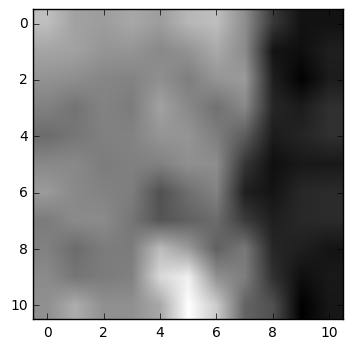

In [32]:
imshow(a[0,5,:,:], cmap='gray')

In [45]:
#test_pat_sitk = sitk.ReadImage('LabelMaps/64/case.nrrd')
test_pat = sitk.GetArrayFromImage(sitk.ReadImage('../testing_pat/002/case.nrrd')).astype(np.float32)
test_pat = test_pat[140:,15:180,80:230]
test_pat = pad_volume(test_pat, half_patch_size=half_patch_size)

pat_sitk = sitk.GetImageFromArray(test_pat.astype(np.float32))
sitk.WriteImage(pat_sitk, '../test_pat.nrrd')

final_label = np.zeros_like(test_pat)
test_pat.shape

(74, 175, 160)

In [46]:
z_size, x_size, y_size = test_pat.shape

for z in xrange(half_patch_size, z_size-half_patch_size):
    print(z)
    for x in xrange(half_patch_size, x_size-half_patch_size):
        for y in xrange(half_patch_size, y_size-half_patch_size):
            patient_patch_img = test_pat[z-half_patch_size:z+half_patch_size+1,x-half_patch_size:x+half_patch_size+1,y-half_patch_size:y+half_patch_size+1]
            #patient_patch = patchimg2differentview(patient_patch_img).reshape((1,3*((2*half_patch_size)+1),(2*half_patch_size)+1,(2*half_patch_size)+1)).astype(np.float32)
            patient_patch = patient_patch_img.reshape((1,(2*half_patch_size)+1,(2*half_patch_size)+1,(2*half_patch_size)+1)).astype(np.float32)
            patient_patch -= m
            patient_patch /= s
            predicted_label = int(predict_fn(patient_patch)[0])
            
            final_label[z,x,y] = predicted_label

final_label_sitk = sitk.GetImageFromArray(final_label)
sitk.WriteImage(final_label_sitk, '../test_label.nrrd')

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


In [47]:
print("Done!")

Done!
